In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE as SklearnTSNE 

sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")
print(f"NumPy Version: {np.__version__}") 
print(f"Scikit-learn Version: {sklearn.__version__}")

torch.manual_seed(42)
np.random.seed(42)

PyTorch Version: 2.3.0+cu118
NumPy Version: 1.24.3
Scikit-learn Version: 1.2.2


#### Dimensionality Reduction

Dimensionality Reduction: The process of reducing the number of random variables (features)
under consideration, by obtaining a set of principal variables.
</br></br>
Why Reduce Dimensions?
- Visualization: High-dimensional data (more than 3 features) is hard to visualize.
- Computational Efficiency: Fewer features can lead to faster model training.
- Noise Reduction: Can remove irrelevant or noisy features.
- Overcoming the Curse of Dimensionality: High-dimensional spaces can be sparse, making it harder for models to learn.

In [3]:
digits = load_digits()
X_digits_np = digits.data   # (n_samples, n_features=64)
y_digits_np = digits.target # (n_samples,)

print(f"Original Digits data shape: {X_digits_np.shape}")
print(f"Number of unique classes (digits): {len(np.unique(y_digits_np))}")

Original Digits data shape: (1797, 64)
Number of unique classes (digits): 10


In [4]:
scaler_digits = StandardScaler()
X_digits_scaled_np = scaler_digits.fit_transform(X_digits_np)

In [5]:
X_digits_tensor = torch.from_numpy(X_digits_scaled_np).float()
y_digits_tensor = torch.from_numpy(y_digits_np).long()

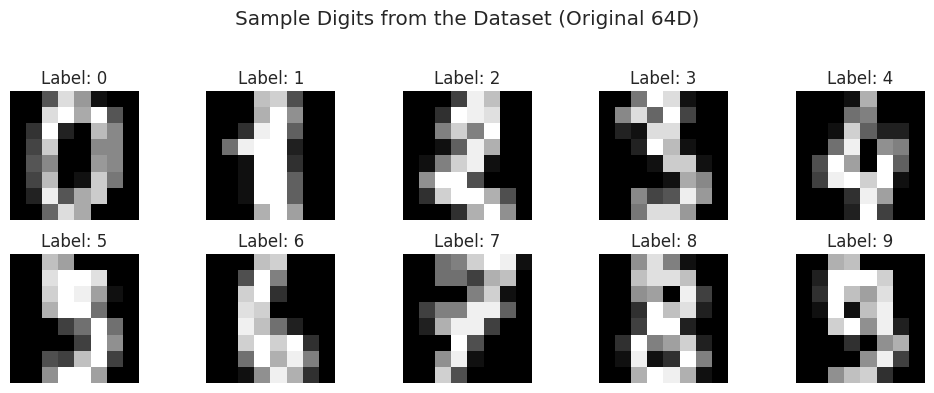

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(X_digits_np[i].reshape(8, 8), cmap='gray')
    axes[i].set_title(f"Label: {y_digits_np[i]}")
    axes[i].axis('off')
plt.suptitle("Sample Digits from the Dataset (Original 64D)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Principal Component Analysis (PCA)

In [7]:
class PyTorchPCA:
    def __init__(self, n_components=None):
        self.n_components_ = n_components
        self.mean_ = None
        self.components_ = None # Principal axes in feature space (V_k.T)
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None

    def fit(self, X_tensor):
        """
        Assumes X_tensor is already centered if mean subtraction is desired globally.
        For strict PCA, data should be centered. Our input is StandardScaler output, so it's centered.
        """
        n_samples, n_features = X_tensor.shape
        X_centered = X_tensor # Assuming input X_tensor is already centered (e.g., by StandardScaler)

        # Perform SVD: X_centered = U @ diag(S_vec) @ V^T
        U, S_vec, V = torch.linalg.svd(X_centered, full_matrices=False)

        principal_axes = V 
        explained_variance_full = (S_vec**2) / (n_samples - 1) # if n_samples > 1 else S_vec**2 / n_samples
        total_variance = torch.sum(explained_variance_full)
        explained_variance_ratio_full = explained_variance_full / total_variance

        if self.n_components_ is None:
            self.n_components_ = n_features
        
        self.components_ = principal_axes[:, :self.n_components_] 
        self.explained_variance_ = explained_variance_full[:self.n_components_]
        self.explained_variance_ratio_ = explained_variance_ratio_full[:self.n_components_]
        
        print(f"  Selected {self.n_components_} components.")
        print(f"  Shape of components_ (V_k): {self.components_.shape}")

    def transform(self, X_tensor):
        if self.components_ is None:
            raise RuntimeError("PCA not fitted yet. Call fit() first.")
        X_centered = X_tensor
        X_pca = X_centered @ self.components_
        return X_pca

    def fit_transform(self, X_tensor):
        self.fit(X_tensor)
        return self.transform(X_tensor)

In [8]:
N_COMPONENTS_PCA = 2 # Reduce to 2 components for visualization
pca_torch = PyTorchPCA(n_components=N_COMPONENTS_PCA)
X_digits_pca_torch = pca_torch.fit_transform(X_digits_tensor)

  Selected 2 components.
  Shape of components_ (V_k): torch.Size([64, 2])


In [9]:
print(f"\nShape of data after PyTorch PCA: {X_digits_pca_torch.shape}") # Should be (n_samples, N_COMPONENTS_PCA)
print(f"Explained variance by component: {pca_torch.explained_variance_.numpy()}")
print(f"Explained variance ratio by component: {pca_torch.explained_variance_ratio_.numpy()}")
print(f"Total explained variance ratio: {torch.sum(pca_torch.explained_variance_ratio_).item():.4f}")


Shape of data after PyTorch PCA: torch.Size([1797, 2])
Explained variance by component: [7.3447723 5.835487 ]
Explained variance ratio by component: [0.12033917 0.09561054]
Total explained variance ratio: 0.2159


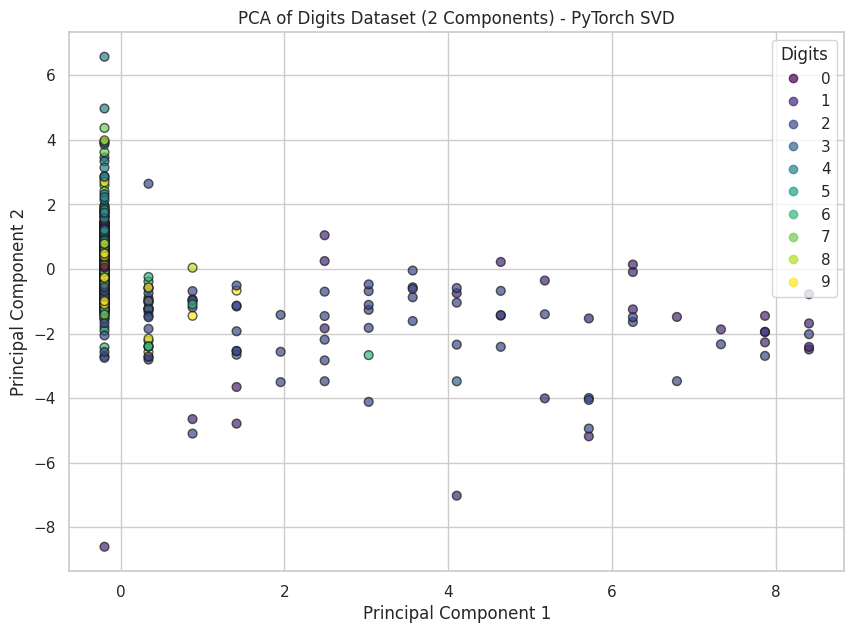

In [12]:
# visualize pca result
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_digits_pca_torch[:, 0].detach().numpy(),
    X_digits_pca_torch[:, 1].detach().numpy(),
    c=y_digits_np, 
    cmap='viridis',
    alpha=0.7,
    edgecolors='k',
    s=40
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"PCA of Digits Dataset ({N_COMPONENTS_PCA} Components) - PyTorch SVD")

legend_labels = [str(name) for name in digits.target_names]
handles, _ = scatter.legend_elements() 
if len(handles) > len(legend_labels): 
    handles = handles[:len(legend_labels)]
elif len(legend_labels) > len(handles): 
    legend_labels = legend_labels[:len(handles)]
plt.legend(handles=handles, labels=legend_labels, title="Digits")
plt.grid(True)
plt.show()

  Selected 64 components.
  Shape of components_ (V_k): torch.Size([64, 64])


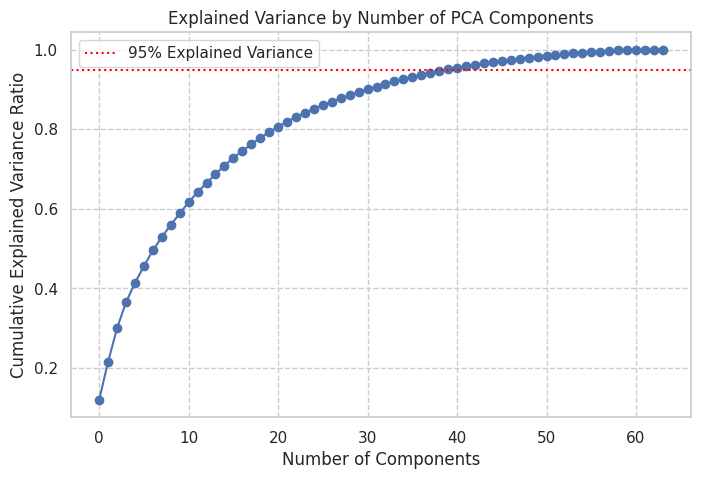

In [15]:
pca_torch_all_components = PyTorchPCA()
pca_torch_all_components.fit(X_digits_tensor)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_torch_all_components.explained_variance_ratio_.numpy()), marker='o', linestyle='-')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Explained Variance by Number of PCA Components")
plt.grid(True, which="both", ls="--")
plt.axhline(0.95, color='red', linestyle=':', label='95% Explained Variance') # Example threshold
plt.legend()
plt.show()

#### T-distributed Stochastic Neighbor Embedding (t-SNE)
A non-linear dimensionality reduction technique primarily used for visualization of high-dimensional datasets in low dimensions. 

In [16]:
# SKlearn's TSNE
N_COMPONENTS_TSNE = 2
PERPLEXITY = 30.0
N_ITER_TSNE = 1000
LEARNING_RATE_TSNE = 'auto'

In [17]:
X_digits_tensor.shape

torch.Size([1797, 64])

In [18]:
tsne_sk = SklearnTSNE(
    n_components=N_COMPONENTS_TSNE,
    perplexity=PERPLEXITY,
    n_iter=N_ITER_TSNE,
    learning_rate=LEARNING_RATE_TSNE,
    init='pca',
    random_state=42,
    n_jobs=-1
    )

In [20]:
tsne_sk

TSNE(n_jobs=-1, random_state=42)

In [21]:
X_digits_tsne_sk = tsne_sk.fit_transform(X_digits_tensor)

In [23]:

X_digits_tsne_sk[:5]

array([[ 38.770164 , -30.871126 ],
       [ 15.183001 ,  -2.8749793],
       [ -6.081013 , -14.676033 ],
       [-28.562302 ,   2.5605733],
       [ 36.350883 ,   2.5571516]], dtype=float32)

In [24]:
X_digits_tsne_sk.shape

(1797, 2)

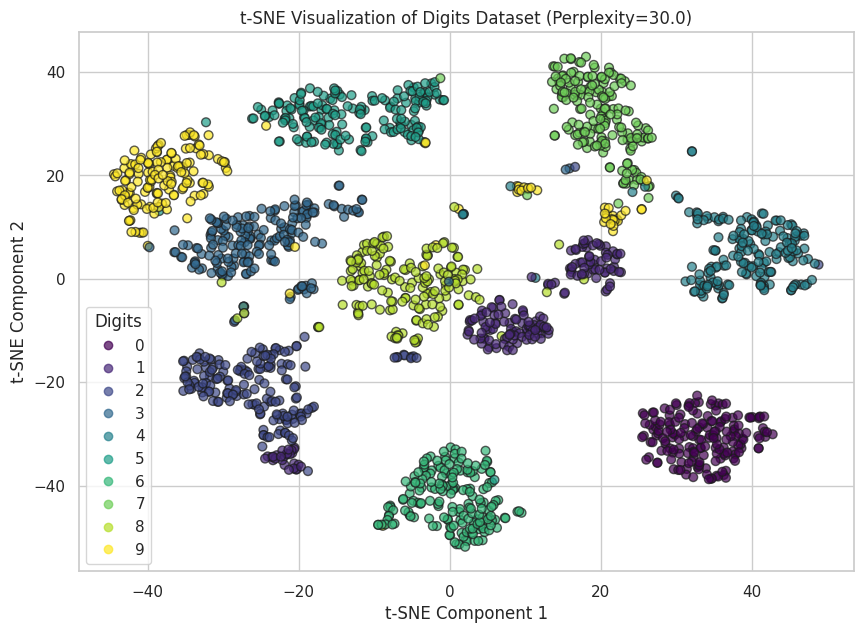

In [28]:
plt.figure(figsize=(10, 7))
scatter_tsne = plt.scatter(
    X_digits_tsne_sk[:, 0],
    X_digits_tsne_sk[:, 1],
    c=y_digits_np, 
    cmap='viridis', 
    alpha=0.7,
    edgecolors='k',
    s=40
)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title(f"t-SNE Visualization of Digits Dataset (Perplexity={PERPLEXITY})")
legend_labels = [str(name) for name in digits.target_names]
handles, _ = scatter.legend_elements() 
if len(handles) > len(legend_labels): 
    handles = handles[:len(legend_labels)]
elif len(legend_labels) > len(handles): 
    legend_labels = legend_labels[:len(handles)]
plt.legend(handles=handles, labels=legend_labels, title="Digits")
plt.grid(True)
plt.show()